In [3]:
import numpy as np
import scipy as sp
import pandas as pd

import time
from matplotlib import pyplot as plt

**Homework:**

1. Create a new signal of frequency 10kHz, amplitude 5V, DC offset of 2.5 V. Then digitise the signal using 4 bits per value. You will need to play around with the bit depth and the range.
2. Modify the ADC to add noise to the signal, then average the noisy values. You may want to look at [Michael's Notes](https://github.com/phys3112/intro/blob/master/mcba3-analog-to-digital-conversion.ipynb) for inspiration.

In [4]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Making our adc function! This is not the most efficient way of doing it, but I hope it's easier to understand.
def adc1(signal, num_bits, input_range):
    # A function to digitise an analogue signal
        # Signal is a list or 1D array of all the values
        # num_bits is the number of bits (1s or zeros) we will have in our ADC
        # input_range is the range of inputs we will allow, as a tuple (min, max)
    
    # Extract the min and max values from the input range
    sig_min, sig_max = input_range
    # Generate the discrete levels that our ADC is going to map the real signal to
    disc_levels = np.linspace(sig_min, sig_max, 2**num_bits)
    print(disc_levels)
    
    # For each element in the signal, match it to the closest discrete level:
    out = list() # Create an empty output array
    for i in signal:
        out.append(find_nearest(disc_levels,i))
        
    return out

[-2.5        -1.83333333 -1.16666667 -0.5         0.16666667  0.83333333
  1.5         2.16666667  2.83333333  3.5         4.16666667  4.83333333
  5.5         6.16666667  6.83333333  7.5       ]


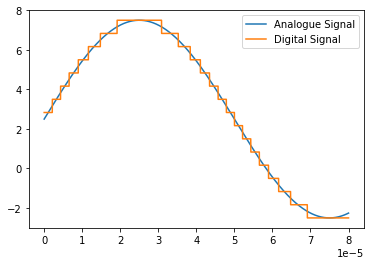

In [5]:
# We have made a BASIC digitiser - check it out above.
# Let's test it out using a sinusoid
samples = 100000
final = 0.00008
timebase = np.arange(0, final, final/samples)
signal = 5*np.sin(2*np.pi*10**4*timebase) + 2.5
plt.plot(timebase,signal,'-')

plt.plot(timebase,adc1(signal, 4, (-2.5,7.5)),'-')
plt.legend(["Analogue Signal", "Digital Signal"])

**Homework**

1. Try out some other input signals such as your own experimental data, ExpData.txt or BeatsHighRaw.txt)
2. Try out an inverse fourier transform, how does it compare to the original data?
3. Have a look at 2d fourier transforms (they are pretty cool)

In [6]:
from scipy import signal
import scipy.fftpack

length: 600


Text(0.5, 0, 'Time (s)')

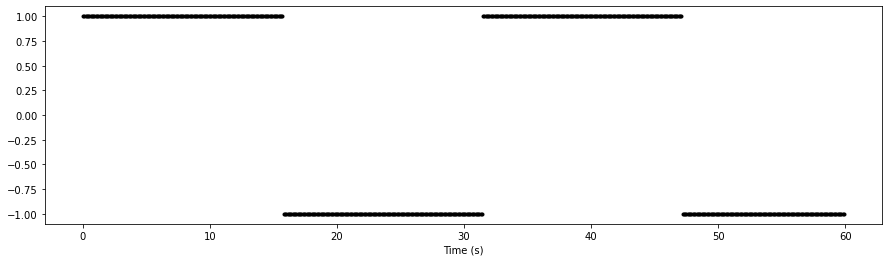

In [7]:
# Lets make the function we will be transforming

# Generate our timebase
timestep = 0.1 # sec

finaltime = 60 # sec
steps = int(finaltime/timestep)

timebase = np.arange(0,finaltime,timestep) 
print("length: " + str(len(timebase)))

frequency = 0.5*np.pi # rad/sec

my_signal = np.sin(timebase*frequency) # Generate our sinusoid, and plot it!

# frequency2 = 1.1*np.pi
# my_signal = np.sin(timebase*frequency) + np.sin(timebase*frequency2)

my_signal =  sp.signal.square(0.2*timebase)

plt.figure(figsize=(15, 4))
plt.plot(timebase, my_signal,'k.')
plt.xlabel('Time (s)')

In [10]:
dataTable = pd.read_csv('BeatsHighRaw.txt',sep='\t',header=1) # Setting what row to read as our heading
dataTable.columns = ["t", "v", "v1"] # renaming columns headings
dataTable = dataTable[["t", "v"]]
dataTable # printing the table

,t,v
0,0.0,0.00
1,0.0,0.00
2,0.0,0.00
3,0.0,0.00
4,0.0,0.00
...,...,...
238995,119.5,-0.31
238996,119.5,-0.31
238997,119.5,-0.30
238998,119.5,-0.30


In [11]:
fixedTable = dataTable.groupby(dataTable['t'],as_index=False).aggregate({'v':'mean'}) # We dont want to use t as an index
fixedTable

,t,v
0,0.00,0.000000
1,0.01,0.000500
2,0.02,0.001053
3,0.03,0.006500
4,0.04,0.009000
...,...,...
11946,119.46,-0.324286
11947,119.47,-0.319000
11948,119.48,-0.314211
11949,119.49,-0.307500


Text(0.5, 0, 'Time (s)')

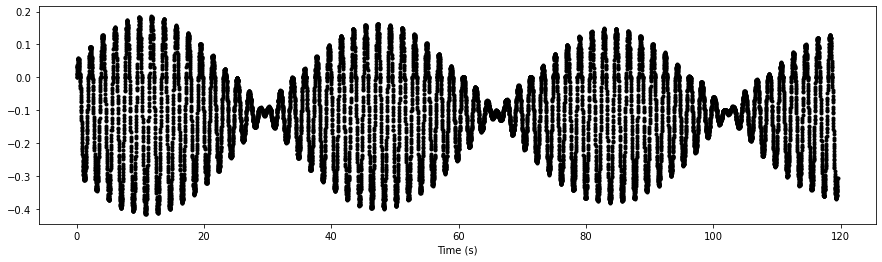

In [22]:
timebase = fixedTable.t.to_numpy()
my_signal = fixedTable.v.to_numpy()
steps = len(fixedTable.t)
timestep =  0.01

plt.figure(figsize=(15, 4))
plt.plot(timebase, my_signal,'k.')
plt.xlabel('Time (s)')

[-1.36880144e+03 -0.j         -4.15515407e+00 +1.96788611j
 -4.31387061e+00 +3.10433429j -1.24771981e+01+17.03691995j
  1.08500683e+00 -8.28321801j]


Text(0.5, 0, 'Frequency (Hz)')

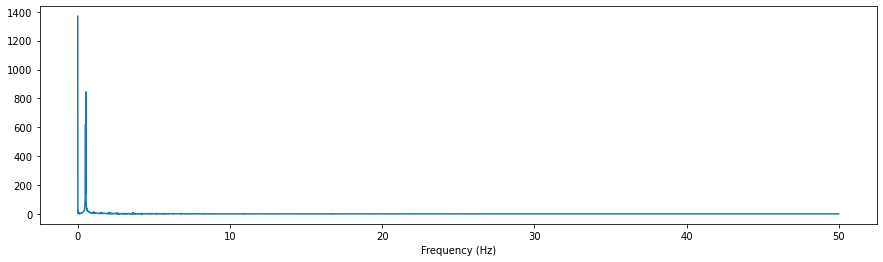

In [23]:
fftsignal = sp.fftpack.fft(my_signal) # Doing the fourer transform
print(fftsignal[0:5])

freqbase = sp.fftpack.fftfreq(steps, d=timestep) # Generates our frequency base

fftsignal = np.abs(fftsignal) # Step 1 - take the absolute value of our fourier transform
fftsignal = fftsignal[:steps//2] # Step 2 - take only the second half of our fourier transform (it's mirrored about f = 0) 
freqbase = freqbase[:steps//2]

plt.figure(figsize=(15, 4))
lastidx = 9999 # using this to zoom in on the graph
plt.plot(freqbase[0:lastidx], fftsignal[0:lastidx])
plt.xlabel('Frequency (Hz)')

In [25]:
fourier = pd.DataFrame({ "Mag" : fftsignal, "Freq" : freqbase})
fourier.sort_values(by=['Mag'], ascending = False) # Finding the peaks

,Mag,Freq
0,1368.801445,0.000000
64,845.388463,0.535520
61,620.255233,0.510418
60,411.285092,0.502050
62,174.245472,0.518785
...,...,...
5467,0.006569,45.745126
5499,0.005582,46.012886
5853,0.004921,48.974981
2286,0.004151,19.128106
